<a href="https://colab.research.google.com/github/Kaiziferr/deep_learning/blob/master/multilayer_perceptron/03_clasification_sonar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 18.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [ ]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score
)

from sklearn.preprocessing import (LabelEncoder, StandardScaler)
from sklearn.pipeline import Pipeline

from scikeras.wrappers import KerasClassifier

# **Info**
---
@By: **Steven Bernal**

@Nickname: **Kaiziferr**

@Git: https://github.com/Kaiziferr

@References: This concept test is an adaptation of a workshop from the [Deep Learning con Python y Keras. Redes Neuronales avanzado.](https://www.udemy.com/course/deep-learning-con-keras/?couponCode=LEADERSALE24B)course.


# **Config**
---

In [ ]:
sns.set(style="darkgrid")
pd.set_option('display.float_format', '{:,.3f}'.format)
warnings.simplefilter("ignore")
title_data = 'Detección de minas y rocas'
paleta = sns.color_palette("tab10").as_hex()
random_seed = 12354

# **Descripcion**
---
El archivo "sonar.mines" contiene 111 patrones obtenidos al hacer rebotar señales de sonar en un cilindro de metal en varios ángulos y bajo diversas condiciones. El archivo "sonar.rocks" contiene 97 patrones obtenidos de rocas en condiciones similares. La señal del sonar transmitida es un chirrido de frecuencia modulada, aumentando en frecuencia. El conjunto de datos contiene señales obtenidas desde una variedad de ángulos de aspecto diferentes, que abarcan 90 grados para el cilindro y 180 grados para la roca.

Cada patrón es un conjunto de 60 números en el rango de 0,0 a 1,0. Cada número representa la energía dentro de una banda de frecuencia particular, integrada durante un cierto período de tiempo. La apertura de integración para frecuencias más altas ocurre más tarde en el tiempo, ya que estas frecuencias se transmiten más tarde durante el chirrido.

La etiqueta asociada a cada registro contiene la letra "R" si el objeto es una roca y "M" si es una mina (cilindro de metal). Los números en las etiquetas están en orden creciente de ángulo de aspecto, pero no codifican el ángulo directamente.




# **Objetivos**
---

Distinguir entre `rocas` y `estructuras metálicas`, como minas marinas en el fondo marino.

Optimizar el rendimiento con procesamiento de datos con:
- pipelines


# **Dicionario de datos**
---
- [V1:V60] señales de sonar
- Class: tipo de elemento
  - 0 Minas
  - 1 Rocas

# **Data**
---

In [ ]:
url = 'https://raw.githubusercontent.com/selva86/datasets/master/Sonar.csv'
data = pd.read_csv(url)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,Class
0,0.020,0.037,0.043,0.021,0.095,0.099,0.154,0.160,0.311,0.211,0.161,0.158,0.224,0.065,0.066,0.227,0.310,0.300,0.508,0.480,0.578,0.507,0.433,0.555,0.671,0.641,0.710,0.808,0.679,0.386,0.131,0.260,0.512,0.755,0.854,0.851,0.669,0.610,0.494,0.274,0.051,0.283,0.282,0.426,0.264,0.139,0.105,0.134,0.038,0.032,0.023,0.003,0.006,0.016,0.007,0.017,0.018,0.008,0.009,0.003,1
1,0.045,0.052,0.084,0.069,0.118,0.258,0.216,0.348,0.334,0.287,0.492,0.655,0.692,0.780,0.746,0.944,1.000,0.887,0.802,0.782,0.521,0.405,0.396,0.391,0.325,0.320,0.327,0.277,0.442,0.203,0.379,0.295,0.198,0.234,0.131,0.418,0.384,0.106,0.184,0.197,0.167,0.058,0.140,0.163,0.062,0.020,0.053,0.074,0.041,0.006,0.013,0.008,0.009,0.005,0.009,0.019,0.014,0.005,0.005,0.004,1
2,0.026,0.058,0.110,0.108,0.097,0.228,0.243,0.377,0.560,0.619,0.633,0.706,0.554,0.532,0.648,0.693,0.676,0.755,0.893,0.862,0.797,0.674,0.429,0.365,0.533,0.241,0.507,0.853,0.604,0.851,0.851,0.504,0.186,0.271,0.423,0.304,0.612,0.676,0.537,0.472,0.465,0.259,0.213,0.222,0.211,0.018,0.135,0.074,0.013,0.011,0.003,0.023,0.017,0.009,0.018,0.024,0.032,0.016,0.009,0.008,1
3,0.010,0.017,0.062,0.021,0.021,0.037,0.110,0.128,0.060,0.126,0.088,0.199,0.018,0.226,0.173,0.213,0.069,0.228,0.406,0.397,0.274,0.369,0.556,0.485,0.314,0.533,0.526,0.252,0.209,0.356,0.626,0.734,0.612,0.350,0.395,0.301,0.541,0.881,0.986,0.917,0.612,0.501,0.321,0.320,0.429,0.365,0.266,0.158,0.068,0.029,0.024,0.012,0.004,0.015,0.009,0.007,0.005,0.004,0.004,0.012,1
4,0.076,0.067,0.048,0.039,0.059,0.065,0.121,0.247,0.356,0.446,0.415,0.395,0.426,0.413,0.453,0.533,0.731,0.619,0.203,0.464,0.415,0.429,0.573,0.540,0.316,0.229,0.700,1.000,0.726,0.472,0.510,0.546,0.288,0.098,0.195,0.418,0.460,0.322,0.283,0.243,0.198,0.244,0.185,0.084,0.069,0.053,0.036,0.009,0.023,0.005,0.016,0.003,0.005,0.011,0.011,0.002,0.007,0.005,0.011,0.009,1


In [ ]:
data_values = data.values

# **split**
---

In [ ]:
X = data_values[:, :60].astype('float32')
y = data_values[:, 60]

In [ ]:
y

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [ ]:
X_train, x_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size = 0.7,
    random_state =  random_seed,
    shuffle = True
)

In [ ]:
data['tags'] = data['Class'].replace({0: 'roca', 1: 'mina'})

In [ ]:
def plot_bar(data:pd.DataFrame, paleta:list=None, figsize_x:int=8, figsize_y:int=5,
             fontsize:int=15, **kwards)->None:
  """Grafica un diagrama de barras con multiples caracteristicas"""
  try:
    paleta = paleta if paleta !=None else sns.color_palette("tab10").as_hex()
    v = kwards
    ejeX = v["ejeX"]

    fig, ax = plt.subplots(figsize = (figsize_x, figsize_y))
    fig.suptitle(f'Diagrama de barras {v["title"]}', fontsize=fontsize)

    if type(ejeX) == str:
      sns.countplot(x=ejeX, data=data, ax = ax, palette=paleta)
    else:
      ejeX = v['ejeX'][0]
      sns.countplot(x=ejeX, hue=v['ejeX'][1], data=data, ax=ax, palette=paleta)

    ax.set_ylabel(v['ejey'], size = 12)
    ax.set_xlabel(ejeX, size=fontsize-3)

    ax.set_xticklabels(ax.get_xticklabels(), fontsize = fontsize-3)
    for p in ax.patches:
      try:
        height = int(p.get_height())
        height_text = height
        if kwards['p'] == True:
          percentage = round(height/data.shape[0], 5)
          height_text = f'{height} ({percentage})'
        ax.text(p.get_x()+p.get_width()/2., height + 1, height_text, ha="center")
      except:
        pass

  except Exception as e:
    print(e)


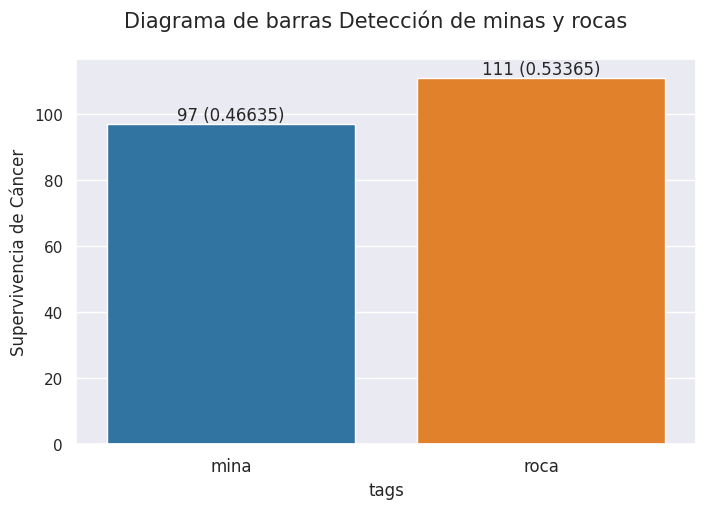

In [ ]:
plot_bar(
    data,
    paleta=paleta,
    ejeX='tags',
    ejey='Supervivencia de Cáncer',
    title=title_data,
    p=True)

- El conjunto se encuntra parcialmente equilibrado

In [ ]:
def model_base():
  model = Sequential()
  model.add(
      Dense(
          60, input_dim = 60, kernel_initializer='glorot_uniform', activation='relu'))
  model.add(Dense(1, kernel_initializer='glorot_uniform', activation='relu'))
  model.compile(loss = 'binary_crossentropy', optimizer = 'adam')
  return model

In [ ]:
model = KerasClassifier(build_fn=model_base, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed)
score = cross_val_score(model, X, y, cv=kfold)

In [ ]:
score

array([0.52380952, 0.80952381, 0.9047619 , 0.80952381, 0.85714286,
       0.85714286, 0.9047619 , 0.80952381, 0.9       , 0.8       ])

- El modelo sufre de variabilidad minima, puesto sus puntajes se encuentran en el orden de los 0.8-0.9, solo hay un pliegue bajo.

In [ ]:
print('Base Line: %.2f%% (%.2f%%)' % (score.mean()*100, score.std()*100))

Base Line: 81.76% (10.58%)


La dispersión es minima, pero considerable frente a la media para este tipo de problema, lo que indica ruido estadistico, por lo tanto es posible que el rendimiento se vea afectado.

# **Optimizar el rendimiento con procesamiento de datos**
---

In [ ]:
estimator = []
estimator.append(('standarize', StandardScaler()))
estimator.append(('mlp', KerasClassifier(
    build_fn=model_base, epochs=100, batch_size=5, verbose=0
)))

In [ ]:
pipeline = Pipeline(estimator)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed)
score = cross_val_score(pipeline, X, y, cv=kfold)

In [ ]:
score

array([0.76190476, 0.95238095, 0.85714286, 0.61904762, 0.80952381,
       0.9047619 , 0.80952381, 0.76190476, 0.65      , 0.8       ])

- Los resultados convergen tiene un convergencia similar al anterior, pero su variabilidad es minimamente menor.

In [ ]:
print("Modelo Estandarizado: %.2f%% (%.2f%%)" % (score.mean()*100, score.std()*100))

Modelo Estandarizado: 79.36% (10.22%)


La dispersión es más baja que el modelo base, por lo tanto la habilidad predictiva es más confiable que el base.

# **Topologias**
---

## **Topologia Pequeña**
---

In [ ]:
def model_smaller():
  model = Sequential()
  model.add(Dense(30, input_dim=60, kernel_initializer='glorot_uniform', activation='relu'))
  model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
estimator = []
estimator.append(('standarize', StandardScaler()))
estimator.append(('mlp',
                  KerasClassifier(
                      build_fn=model_smaller,
                      epochs = 100,
                      batch_size = 5,
                      verbose = 0
                  )))


In [ ]:
pipeline = Pipeline(estimator)
score = cross_val_score(pipeline, X, y, cv=kfold)
score

array([0.85714286, 0.95238095, 0.9047619 , 0.80952381, 0.9047619 ,
       0.76190476, 0.85714286, 0.85714286, 0.9       , 0.85      ])

In [ ]:
print("Modelo Estandarizado Topologia pequeña: %.2f%% (%.2f%%)" % (score.mean()*100, score.std()*100))

Modelo Estandarizado Topologia pequeña: 86.55% (5.11%)


- El modelo con topologia pequeña, difiere  del rendimiento del modelo base.
- Tiene un buen comportamiento. Una media más alta y una disperción menor al modelo base.

## **Topologia grande**
---

In [ ]:
def model_large():
  model = Sequential()
  model.add(Dense(60, input_dim = 60, kernel_initializer='glorot_uniform', activation= 'relu'))
  model.add(Dense(60, kernel_initializer='glorot_uniform', activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
  return model

In [ ]:
estimators = []
estimators.append(("standarize", StandardScaler()))
estimators.append(('mlp', KerasClassifier(
    build_fn=model_large, epochs=100, batch_size=5, verbose=0
)))

In [ ]:
pipeline = Pipeline(estimator)
score = cross_val_score(pipeline, X, y, cv = kfold)

In [ ]:
score

array([0.85714286, 0.9047619 , 0.80952381, 0.76190476, 0.9047619 ,
       0.85714286, 0.80952381, 0.9047619 , 0.9       , 0.8       ])

In [ ]:
print("Modelo Estandarizado Topologia grande: %.2f%% (%.2f%%)" % (score.mean()*100, score.std()*100))

Modelo Estandarizado Topologia grande: 85.10% (5.01%)


- La topologia grande no tubo una mejora significativa en comparación a la arquitectura pequeña, cabe resaltar que no se entro en profundidad. La topologia, tiene un mejor rendimiento, y su dispersión es más baja.

# **Info**
---
@By: **Steven Bernal**

@Nickname: **Kaiziferr**

@Git: https://github.com/Kaiziferr

@References: This concept test is an adaptation of a workshop from the [Deep Learning con Python y Keras. Redes Neuronales avanzado.](https://www.udemy.com/course/deep-learning-con-keras/?couponCode=LEADERSALE24B)course.
